In [102]:
import pandas as pd
import numpy as np
import fastcore
import math
from tsai.all import *

In [245]:
lengths = pd.read_csv('../tmp/regime_data_lengths.csv')
regime_data = pd.read_csv('../tmp/regime_data.csv')

In [246]:
regime_data

,Unnamed: 0,price,delta,volume,duration,vol_0_0,dir_1_0,vol_0_1,dir_1_1,vol_0_2,...,vol_8_40,dir_9_40,vol_8_41,dir_9_41,vol_8_42,dir_9_42,vol_8_43,dir_9_43,vol_8_44,dir_9_44
0,0,37885.7,-0.000084,7.012500,185472,0.389482,-0.129939,0.374458,-0.148761,0.437590,...,0.234345,-0.635084,0.233129,-0.603714,0.230064,-0.579394,0.225062,-0.529731,0.218769,-0.484540
1,1,37748.2,0.003627,6.679470,156384,0.363771,-0.104040,0.409633,-0.133741,0.361404,...,0.227907,-0.645555,0.228947,-0.603589,0.226767,-0.586164,0.223386,-0.549603,0.217909,-0.497625
2,2,37601.6,0.003885,4.365970,69652,0.336587,-0.089243,0.314825,-0.119748,0.322100,...,0.220356,-0.690645,0.225022,-0.633518,0.224254,-0.608563,0.221808,-0.589829,0.218037,-0.545509
3,3,37696.7,-0.002531,15.202100,166335,0.314548,-0.083066,0.294307,-0.109563,0.297898,...,0.214048,-0.744868,0.220610,-0.689042,0.222141,-0.652602,0.220342,-0.639471,0.217819,-0.607041
4,4,37847.5,-0.004000,9.105710,216734,0.322176,-0.070908,0.319214,-0.094121,0.308879,...,0.207469,-0.730647,0.212141,-0.697358,0.217056,-0.647428,0.216539,-0.627998,0.214510,-0.614113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7896,7896,34035.3,-0.004000,1.611190,66243,0.566393,-0.074262,0.626777,-0.043203,0.694599,...,0.243466,0.208042,0.239466,0.201372,0.234871,0.182021,0.233015,0.171751,0.230760,0.168881
7897,7897,34089.4,-0.001588,0.537836,8922,0.492425,-0.077093,0.561256,-0.056989,0.619570,...,0.257510,0.183983,0.252071,0.170043,0.247361,0.159945,0.242458,0.145761,0.238520,0.138955
7898,7898,34214.8,-0.003680,0.162058,16391,0.451998,-0.069595,0.496434,-0.060103,0.557326,...,0.265140,0.162103,0.259270,0.149580,0.254878,0.145225,0.248914,0.128282,0.244396,0.119930
7899,7899,34247.9,-0.000967,1.631940,15562,0.604030,-0.049272,0.523407,-0.049671,0.494268,...,0.266661,0.157341,0.262350,0.155733,0.256298,0.143316,0.251135,0.134474,0.245505,0.121444


In [247]:
regime_data_raw = regime_data.to_numpy()[:, 2:]
regime_data_deltas = regime_data.to_numpy()[:, 2]
print(regime_data_raw.shape, regime_data_deltas.shape)

(7901, 453) (7901,)


In [276]:
n_timesteps = 10
step_length = 3
n_samples = (regime_data.shape[0] - (n_timesteps + 1)) // step_length
print(n_samples)
X = np.empty((n_samples, regime_data.shape[1] - 2, n_timesteps))
y = np.empty(n_samples)
for sample_idx in range(n_samples):
    X[sample_idx] = regime_data_raw[sample_idx * step_length :sample_idx * step_length + n_timesteps, :].transpose()
    y[sample_idx] = regime_data_deltas[step_length * sample_idx + 1]
y = np.where(y >= 0, 1.0, -1.0)
split_idx = math.floor(n_samples * 0.7)
splits = toL(np.arange(split_idx)), toL(np.arange(split_idx, n_samples))

2630


In [277]:
X.shape, y.shape, splits

((2630, 453, 10),
 (2630,),
 ((#1840) [0,1,2,3,4,5,6,7,8,9...],
  (#790) [1840,1841,1842,1843,1844,1845,1846,1847,1848,1849...]))

In [279]:
type(X), type(y), type(splits[0])

(numpy.ndarray, numpy.ndarray, fastcore.foundation.L)

X      - shape: [2630 samples x 453 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (2630,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [1840, 790]  overlap: [False]


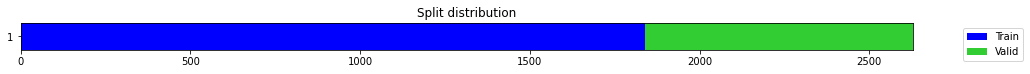

In [280]:
check_data(X, y, splits)

In [281]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=2)
dls.one_batch()

(TSTensor(samples:2, vars:453, len:10), tensor([-1., -1.], device='cuda:0'))

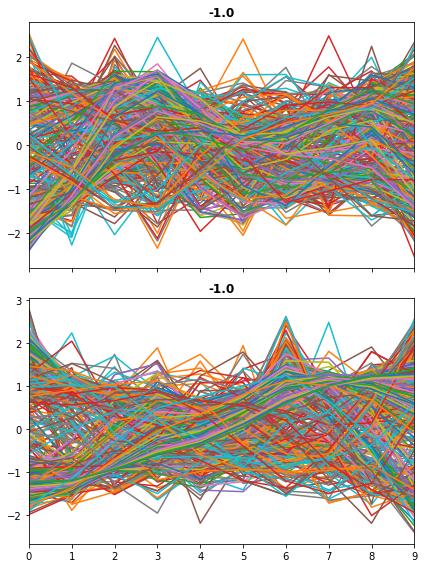

In [282]:
dls.show_batch()

In [291]:
learn = ts_learner(dls, TSTPlus, metrics=[mae, rmse], cbs=ShowGraph())

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=6.309573450380412e-07)

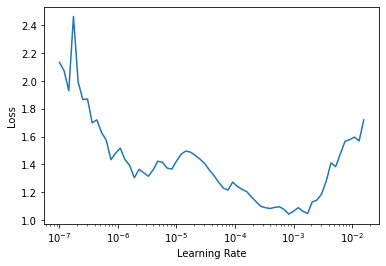

In [294]:
learn.lr_find()

In [295]:
learn.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.774701,0.787462,0.748141,0.887391,00:27
1,0.538228,0.617481,0.646234,0.785799,00:26
2,0.439946,0.422010,0.522859,0.649623,00:27
3,0.350691,0.434170,0.532670,0.658916,00:27
4,0.246913,0.361910,0.483902,0.601590,00:27
5,0.240377,0.392092,0.494004,0.626173,00:27
6,0.201030,0.393079,0.497539,0.626960,00:27
7,0.168720,0.369559,0.485413,0.607914,00:27
8,0.164432,0.410432,0.515463,0.640649,00:27
9,0.121128,0.384990,0.494907,0.620475,00:26


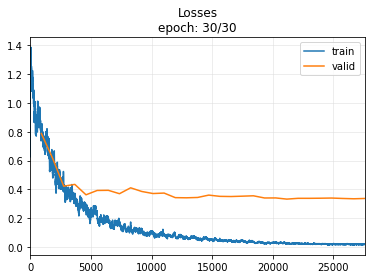

In [296]:
learn.fit_one_cycle(30, 1e-4)

In [297]:
valid_preds, valid_targets = learn.get_preds(ds_idx=1)
valid_preds.flatten().data, valid_targets.data

(tensor([ 0.0146,  0.4872, -0.0563,  0.7167,  0.2412, -0.2216,  0.6352, -0.8651,
         -1.0538, -0.9070, -0.9979, -0.0264, -0.3529,  0.4705,  0.7452,  1.2438,
          1.1632, -0.2393, -1.3003, -1.2619, -0.0863,  0.0134, -0.1857,  1.0701,
          0.1920,  0.4267,  0.3949, -0.5176,  0.6826, -0.3955,  1.0996,  0.2850,
          0.5771,  1.4482,  0.7676,  0.1705,  0.0143, -0.9442, -0.8032, -0.1067,
         -0.5045,  1.0510,  0.5428,  0.2206,  0.7139,  0.2323,  0.2204,  0.8920,
          0.5847, -0.9740,  1.2049, -0.4559, -0.5977, -1.0540,  0.7546,  0.3956,
          0.8642, -0.3601,  1.0185,  0.9444,  0.7679,  0.4389,  1.0959, -0.5318,
         -0.5812,  1.6086, -0.6305,  0.7917,  1.0460, -0.6097,  1.4961, -0.6900,
         -1.1846, -1.1578,  0.7390, -1.2623, -0.6587,  0.8032, -0.6315,  1.1925,
          0.4597,  0.9058, -0.0192,  0.3984,  0.3594, -1.0753, -0.6200, -1.3715,
         -1.2792,  0.7763,  1.0113,  1.2403,  0.9226,  0.7711,  0.7963, -1.1443,
         -0.5981, -0.5228,  

In [298]:
import matplotlib.pyplot as plt

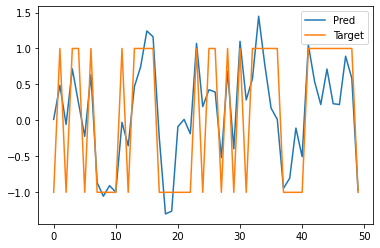

In [304]:
n = 50
plt.plot(valid_preds.flatten().data[:n], label='Pred')
plt.plot(valid_targets.data[:n], label='Target')
plt.legend()

In [306]:
learn.export('regime.pkl')